# Credit Risk Scoring

<p align="left">
  <img src="https://botsify.com/blog/wp-content/uploads/2024/09/credit-score-1024x636.jpg" width="600">
</p>


## Scenario:  
Imagine we work in a bank and when banks receives application for a loan we need to make sure that in case of approving the loan, client will be able to pay out the debt.  
We want to minimize the risks before providing with the loan and check the probability of the default.  
  
Machine Learning can help us to calculate the risks. To build such model we need only the data about previously approved loans with clients' information and whether the debt has been fully paid out or client failed to pay money back.

## 1 - Dataset and Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("CreditScoring.csv")
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


We see that the DataFrame contains the following columns:

- **status** — whether the client managed to repay the loan (1) or not (2);

- **seniority** — length of employment in years;

- **home** — type of home ownership: rent (1), ownership (2), and others;

- **time** — planned loan duration (in months);

- **age** — client’s age;

- **marital_status** — single (1), married (2), etc.;

- **records** — whether the client has any previous records: no (1), yes (2).  
  (The dataset description does not clearly specify what kind of records these are.  
  Given the nature of the project, it is reasonable to assume they refer to records in the bank’s database.)

- **job** — type of employment: full-time (1), part-time (2), and others;

- **expenses** — client’s monthly expenses;

- **income** — client’s monthly income;

- **assets** — total value of the client’s assets;

- **debt** — total amount of outstanding debt;

- **amount** — requested loan amount;

- **price** — price of the item the client wants to purchase.


In [3]:
status_values = { 
    1: 'ok',
    2: 'default',
    0: 'unk'
}
df.status = df.status.map(status_values)


In [4]:
home_values = { 
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
df.home = df.home.map(home_values)

In [5]:
marital_values = { 
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)


In [6]:
records_values = { 
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

In [7]:
job_values = { 
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}
df.job = df.job.map(job_values)

In [8]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


As the next step, let us examine the numerical columns.  
First, we will check the summary statistics for each column: minimum, mean, maximum, and other indicators.


In [9]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The reason we see max as 99999999 for *income*, *assets* and *debt* is because those values are NaN values that have been coded this way.

In [10]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Before finishing the dataset preparation let's have a look at our target variable

In [12]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

In [13]:
# we can remove that one row with unk status
df = df[df.status!='unk']


## 2 - Data Preparation

Now that our dataset has been cleaned, we are almost ready to use it  
to train the model. However, before that, we need to take a few more steps:

- split the dataset into training, validation, and test sets;
- handle missing values;
- apply one-hot encoding for categorical variables;
- create the feature matrix **X** and the target variable **y**.


In [14]:
from sklearn.model_selection import train_test_split

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,
     random_state=11)

In [15]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

The outcome we want to predict is **status**. We will use it to train the model, so this is our **y** — the target variable.

Since the goal is to determine whether someone will default on payments, the positive class is **default**. This means that **y = 1** if the client  
does not repay the loan, and **y = 0** otherwise.


In [16]:
y_train = (df_train.status == 'default').values 
y_val = (df_val.status == 'default').values


In [17]:
del df_train['status'] 
del df_val['status']

In [18]:
df_train = df_train.fillna(0) 
df_val = df_val.fillna(0)

To use categorical variables, we need to encode them.  
In one-hot encoding, each value is encoded as **1** if it is present (“hot”) or **0** if it is absent (“cold”).

`DictVectorizer` requires a list of dictionaries, so first we need to convert the DataFrame into this format:


In [19]:
dict_train = df_train.to_dict(orient='records') 
dict_val = df_val.to_dict(orient='records')

In [20]:
from sklearn.feature_extraction import DictVectorizer
dv = DictVectorizer(sparse=False)


In [21]:
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## 3 - Decision Trees

A decision tree is a data structure that encodes a series of “if–then–else” rules. Each node in the tree contains a condition.  
If the condition is satisfied, we move to the right side of the tree;  otherwise, we move to the left. Eventually, we arrive at a final decision.


### 3.1 - Decision tree clasifier

In [22]:
from sklearn.tree import DecisionTreeClassifier

Model training is implemented by simply calling fit method.

In [23]:
dt = DecisionTreeClassifier() 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


To evaluate the quality of the result, we need to check the predictive performance of the model on the validation set.   
For this purpose, we will use AUC (area under the ROC curve).

Credit risk assessment is a binary classification problem, and for such cases AUC is one of the best metrics.
AUC shows how well the model separates positive examples from  
negative ones.

This metric has a useful interpretation: it describes the probability that a randomly selected positive example (**default**) will receive a higher  
score than a randomly selected negative example (**OK**). This is an important metric for the project: we want risky clients to have higher  
scores than safe ones.


In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
y_pred = dt.predict_proba(X_train)[:, 1] 
roc_auc_score(y_train, y_pred)

1.0

We see the result of 100% Does it  that we can predict the default without any errors?  
Now, let's check the model on validation data.

In [26]:
y_pred = dt.predict_proba(X_val)[:, 1] 
roc_auc_score(y_val, y_pred)

0.6545312537841176

After running the model, we see that the validation AUC is only **65%**.

We have just observed a case of `overfitting`. The tree learned the training data so well that it essentially memorized the outcome for each client.  
However, when we applied it to the validation set, the model made mistakes.

The rules it extracted from the data turned out to be too specific to the training set, so it performed poorly on clients it had not seen during  
training. In such cases, we say that the model cannot generalize.

Overfitting occurs when we have a complex model whose capacity allows it to simply memorize all the training data. If we simplify the model, we can  
make it less powerful and improve its ability to generalize.

There are several ways to control the complexity of a decision tree. One option is to limit its size: we can specify the `max_depth` parameter, which  
controls the maximum number of levels. The more levels a tree has, the more complex rules it can learn.


<p align="left">
  <img src="https://www.statlect.com/images/decision-tree-depth.png" width="600" height="200">
</p>


The default value for `max_depth` is **None** that implies that tree can grow as big as possible.

In [27]:
dt = DecisionTreeClassifier(max_depth=2) 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
from sklearn.tree import export_text
tree_text = export_text(dt, feature_names=dv.feature_names_) 
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- class: True



The condition `records=no > 0.50` means that the client has no records.  
Recall that we use one-hot encoding to represent `records` using two  
features: `records=yes` and `records=no`. For a client who has no records,  
the value of `records=no` is 1, and the value of `records=yes` is 0.  
Therefore, `records=no > 0.50` is true when the value of `records` is **no**.

In [29]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

train auc 0.7054989859726213
validation auc 0.6685264343319367


The validation AUC is now sligthly better, however we got another problem the model is too simple.

### 3.2 - Decision tree learning algorithm

To understand how a decision tree extracts patterns from data, let us simplify the task. First, we will use a much smaller dataset  
with a single feature: **assets**.  
  
  The only feature in our dataset is **assets**.  
That is why the condition in a node will be `assets > T`, where **T** is a threshold value that we need to determine. If the condition is true,  
we predict **OK**; if it is false, our prediction will be **default**.



![Decision tree example](images/decision_trees.png)

Now we turn these groups into leaves—decision nodes—by taking the most frequent status in each group and using it as the final decision.  
In our example, **default** is the most frequent outcome in the left group,  
and **OK** is the most frequent in the right group.


#### Impurity

These groups should be as homogeneous as possible. Ideally, each group  
should contain observations from only one class. In this case, we call such groups *pure*.

For example, if we have a group of four clients with outcomes  `[default, default, default, default]`, then it is pure, since it contains  
only clients who defaulted. But the group `[default, default, default, OK]` has impurity: there is one  
client who did not default.

When training a decision tree model, we want to find such a threshold **T** that the impurities in both groups are minimal.

Thus, the algorithm for finding **T** is quite simple:

- try all possible values of **T**;
- for each **T**, split the dataset into left and right groups and measure  
  their impurity;
- choose the **T** that gives the lowest degree of impurity.


To measure impurity, various criteria can be used.  
The simplest one to understand is the **misclassification error**, which shows how many observations in a group do not belong to the majority class.


Let us compute the misclassification error for the split **T = 4000**.

- **For the left group**, the majority class is **default**.  
  There are four data points in total, and one of them does not belong  
  to **default**. The misclassification error is **25%** (1/4).

- **For the right group**, **OK** is the majority class, and there is  
  one **default** among them. Thus, the misclassification error is also  
  **25%** (1/4).

- **To compute the overall impurity of the split**, we can take the  
  average across both groups. In this case, the average impurity is  
  **25%**.


T = 4000 it is not the only value for splitting the assets. We can try the other values: 2000, 3000 and 5000

![Decision](images/T_values.PNG)

- For **T = 2000**, we have **0%** impurity on the left (0/2, all **default**)  
  and **33.3%** impurity on the right (2/6, 2 out of 6 are **default**, the rest are **OK**).  
  The average impurity is **16.6%**.

- For **T = 3000**, there is **0%** impurity on the left and **20%** (1/5)  
  impurity on the right. The average impurity is **10%**.

- For **T = 5000**, there is **50%** (3/6) impurity on the left and **50%** (1/2)  
  impurity on the right. The average impurity is **50%**.


The best average impurity is **10%** at **T = 3000**: we obtained zero errors  
for the left branch and only one error (out of five rows) for the right one.  
Thus, we should choose **3000** as the threshold for our final model.


Now let's add another feature `debt`.  We do the same steps as for the `assets` to find the best threshold that gives lowest level of impurity.  
For `debt` its value is 1000 in this case average impurity is 17%.


![Decision tree](images/T_values_2.PNG)

#### Stopping criteria

When training a decision tree, we can keep splitting the data until all  
groups become pure. This is exactly what happens when we do not impose  
any restrictions on trees in **scikit-learn**. As we have already seen,  
the resulting model becomes too complex, which leads to overfitting.

We addressed this problem using the `max_depth` parameter, limiting the  
size of the tree and preventing it from growing too large.

To decide whether we want to continue splitting the data, we use  
*stopping criteria*—rules that indicate whether we should add another  
split to the tree or stop.

The most common stopping criteria are:

- the group is already pure;
- the tree has reached the maximum depth (controlled by `max_depth`);
- the group is too small to continue splitting (controlled by the  
  `min_samples_leaf` parameter).

By applying these criteria to stop earlier, we simplify our model and,  
as a result, reduce the risk of overfitting.


### 3.3 Parameter tuning for decision tree

In [30]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1] 
    auc = roc_auc_score(y_val, y_pred) 
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.744
  10 -> 0.681
  15 -> 0.665
  20 -> 0.654
None -> 0.653


After running this code, we see that **max_depth = 5** gives the best AUC  
(**76.6%**), followed by **4** and **6**.  
Next let's set min_leaf_size for that matter we will loop over the 3 best max_depth values.

In [31]:
for m in [4, 5, 6]:
    print('depth: %s' % m)
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (s, auc))
    print()

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.767
5 -> 0.768
10 -> 0.762
15 -> 0.773
20 -> 0.774
50 -> 0.768
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.747
5 -> 0.761
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.772
100 -> 0.776
200 -> 0.768



After running this code we see that the best AUC is 78.5% with parameters min_sample_leaf = 15 and max_depth = 6

In [32]:
#we will use this combination as it gives the highest AUC
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15) 
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,15
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Decision Trees are simple and effective models and they become even more effective when multiple trees are combined together.

## 4 -  Random Forest

One model may fail, but if we combine the results of several models into one, the probability  
of an incorrect answer becomes lower. This concept is called **ensemble  learning**, and a combination of models is called an **ensemble**.

For this to work, the models must be different. If we train the same decision tree model ten times, it will predict exactly the same result,  
making the entire effort pointless.

The simplest way to obtain different models is to train each tree on a different subset of features.


For example, suppose we have three features: **assets**, **debts**, and  
**price**. We can train three models:

- the first uses **assets** and **debts**;
- the second uses **debts** and **price**;
- the last uses **assets** and **price**.

With this approach, we obtain different trees, each of which makes its  
own decisions. But when we combine their predictions, the errors are  averaged out, and overall we achieve better predictive performance.

This method of combining multiple decision trees into an ensemble is  called a **random forest**. To train a random forest, we can do the  
following:

- train **N** independent decision tree models;
- for each model, select a random subset of features and use only them  
  for training;
- during prediction, combine the outputs of the **N** models into one.


### 4.1 - Training a random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

The first thing we have to set during the model training is the number of trees `n_estimators` parameter is used for that.

In [34]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)


,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
y_pred = rf.predict_proba(X_val)[:, 1] 
roc_auc_score(y_val, y_pred)

0.7895394880240245

Each time we retrain the model, the score changes: it varies from  **77% to 80%**.

The reason for this is randomization: when training a tree, we randomly select a subset of objects. To make the results consistent, we need to  
fix the initial value of the random number generator by assigning a specific value to the `random_state` parameter.


In [36]:
rf = RandomForestClassifier(n_estimators=10, random_state=3) 
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
y_pred = rf.predict_proba(X_val)[:, 1] 
roc_auc_score(y_val, y_pred)

0.7811145285897654

Number of trees in ensemble is important parameter, affecting the model performance. Usually, model with more trees work better than the one with fewer.  
On the other side adding too many trees is not always useful.

In [38]:
aucs = []
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)


10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


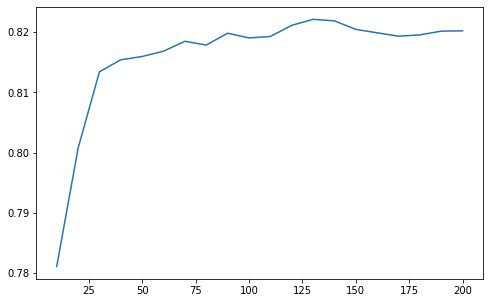

In [42]:
plt.figure(figsize=(8,5))
plt.plot(range(10, 201, 10), aucs)

Performance increases rapidly for the first **25–30 trees**, after which the growth slows down. After about **130 trees**, adding more trees no  
longer affects performance, which remains at approximately **82%**.

The number of trees is not the only parameter that we can adjust to improve performance.
